<a href="https://colab.research.google.com/github/dimandms/motor_temperatures/blob/refactoring/Motors_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Goals of the Notebook are:

1. Prepare EDA, understand main features interactions, prepare new features
2. Try to estimate pm temperature base on measures of currents, voltages, speed, torque and coolant to understand possibility of operations
3. Write clear supported Python code using sklearn Pipelines

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
from typing import List, Dict, Tuple, Callable, Iterable
from enum import Enum
from itertools import product

In [43]:
import numpy as np
import pandas as pd
from pandas.core.groupby import SeriesGroupBy, DataFrameGroupBy
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator

In [45]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/pmsm_temperature_data.csv')

In [46]:
df.head(5)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4.0
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4.0
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4.0
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4.0
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4.0


In [47]:
df.tail(5)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
447033,1.213597,-0.136662,-1.338092,0.315069,1.256531,0.545459,-1.252652,0.463151,0.511155,0.194606,0.420417,0.521998,53.0
447034,1.191186,-0.140209,-1.369103,0.238541,1.241300,0.571222,-1.306237,0.484911,0.513488,0.194769,0.421996,0.525975,53.0
447035,0.385230,-0.240271,-1.423605,0.053742,1.231921,0.614536,-1.443613,0.518100,0.517571,0.194886,0.423170,0.526255,53.0
447036,0.613102,-0.211967,-1.476665,-0.156781,1.235651,0.666284,-1.602808,0.546530,0.520731,0.194969,0.423589,0.526151,53.0
447037,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
df[df.isna().any(axis=1)]

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
447037,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df.dropna(inplace=True)

In [50]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ambient,447037.0,-0.545941,1.066580,-8.573954,-1.135694,-0.391432,0.297613,2.967117
coolant,447037.0,-0.490912,0.860188,-1.429349,-1.070198,-1.042651,-0.100206,2.271667
u_d,447037.0,-0.312512,0.928724,-1.655373,-1.115274,-0.329154,0.297833,2.274734
u_q,447037.0,0.106391,0.903787,-1.861463,-0.702505,0.006741,0.846473,1.793366
motor_speed,447037.0,0.130303,0.985389,-1.371529,-0.689896,-0.077112,0.941943,2.024164
torque,447037.0,0.324993,0.934409,-3.276957,-0.254833,0.341525,0.845668,3.016971
i_d,447037.0,-0.137845,1.052223,-3.245874,-0.987611,0.038149,0.924246,1.060937
i_q,447037.0,0.328384,0.930032,-3.276311,-0.245712,0.308788,0.820970,2.914185
pm,447037.0,-0.188450,1.110109,-2.631991,-1.027167,-0.156329,0.594209,2.917456
stator_yoke,447037.0,-0.386383,0.934120,-1.834688,-1.095658,-0.480506,0.216848,2.393537


As we see with description, all features are scaled. 'profile_id' columns is just the id of running

### Data exploration
Note 1: Profile_id is corresponde to single experiment. Rows of dataframe represent samples and are sorted by time. Sample values is measured within 0.5 seconds (2 Hz)

Note 2: Target features are tempretures (pm, stator_yoke, stator_tooth, stator_winding). Here I will try to estimate permanent magnet temperature (pm)

Questions to answer with DA are:

1. What is duration of profiles?
2. Plot time series charts and. Does it have anomalies?
3. Are features have nonlinear time-dependent behavior?

In [51]:
MEASURES_IN_SECOND = 2
SECONDS_IN_HOUR = 3600

PLOT_STYLE = "darkgrid"
PLOT_PRIMARY_COLOR = "#333333"
PLOT_SECONDARY_COLOR = "#cc9602"

TEMPERATURE_FEATURES = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']
TARGET_FEATURES = TEMPERATURE_FEATURES + ["torque"]

In [52]:
def plot_profile_durations(df: pd.DataFrame) -> None:
    grouped_df = (df.groupby('profile_id')
                    .size()
                    .rename('samples')
                    .reset_index())
    
    with sns.axes_style(PLOT_STYLE):
        _, ax = plt.subplots(1, 1, figsize=(20,3))
        sns.barplot(y='samples', x='profile_id', data=grouped_df, color=PLOT_PRIMARY_COLOR, ax=ax)
        
        hours_ticks: np.ndarray = np.arange(1, 8)
        
        ax.set_yticks(MEASURES_IN_SECOND*SECONDS_IN_HOUR*hours_ticks)
        ax.set_yticklabels([f'{h}' for h in hours_ticks])
        ax.set_ylim((0*MEASURES_IN_SECOND*SECONDS_IN_HOUR, 7*MEASURES_IN_SECOND*SECONDS_IN_HOUR))
        ax.set_ylabel('duration, hours')        

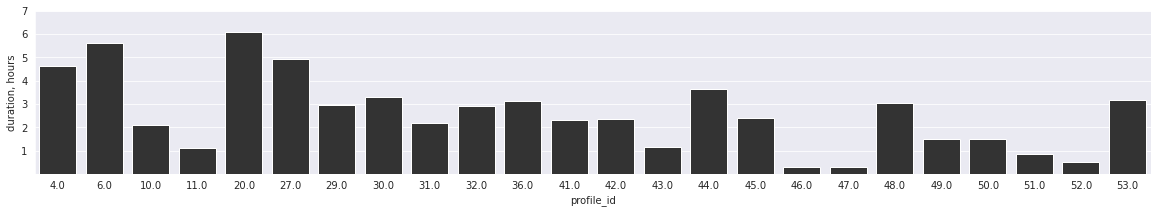

In [53]:
plot_profile_durations(df)

Here we see that some runnings were very short (about 20 minutes) and potentially they have not any interesting insights. Some of it were long and should have insights in data. Let's look at time series charts of target features

In [98]:
def plot_profile_time_series(df: pd.DataFrame, 
                             profile_id: int, 
                             num_of_points: int = None, 
                             features: List[str]=[]) -> None:

    if num_of_points is None:
        filtered_df=df[features][df.profile_id == profile_id].reset_index()
    else:
        filtered_df=df[features][df.profile_id == profile_id].reset_index()[0:num_of_points]

    with sns.axes_style(PLOT_STYLE):
        _, axes = plt.subplots(len(features), 1, figsize=(15, len(features)*2), sharex=True)
        plt.xlabel("sample")

        for ax, feature_name in zip(axes, features):
            ax.plot(filtered_df[feature_name], color=PLOT_PRIMARY_COLOR)
            ax.set_ylabel(feature_name)

In [99]:
def plot_profile_time_series_single_grid(df: pd.DataFrame, 
                                         profile_id: int, 
                                         num_of_points: int = None, 
                                         features: List[str]=[]) -> None:
  
    if num_of_points is None:
      filtered_df=df[features][df.profile_id == profile_id].reset_index()
    else:
      filtered_df=df[features][df.profile_id == profile_id].reset_index()[0:num_of_points]

    with sns.axes_style(PLOT_STYLE):
        _, ax = plt.subplots(1, 1, figsize=(15, 2))
        ax.plot(filtered_df[features[0]], color=PLOT_PRIMARY_COLOR, label=features[0])
        ax.plot(filtered_df[features[1]], color=PLOT_SECONDARY_COLOR, label=features[1])
        ax.set_xlabel('sample')
        ax.legend()

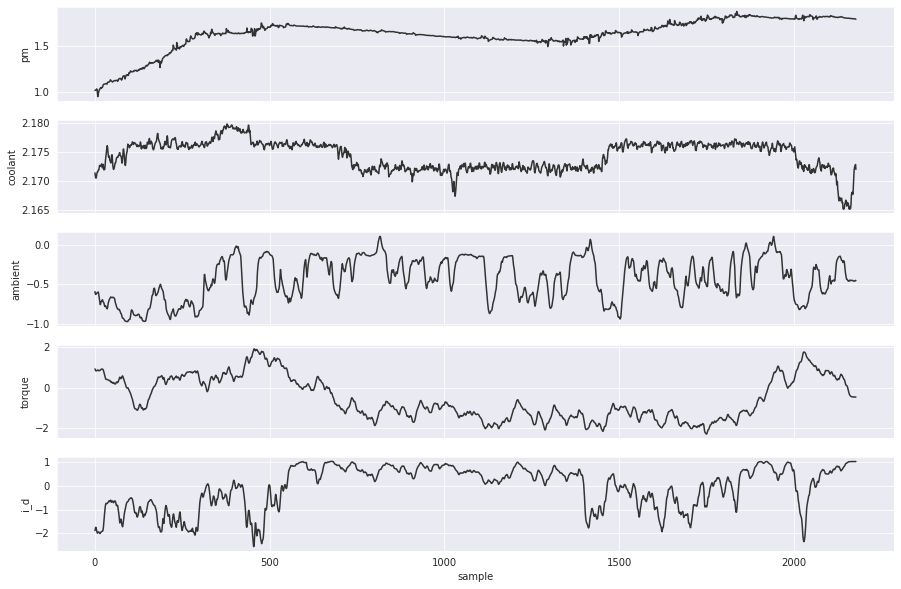

In [56]:
# example of short-time motor running
plot_profile_time_series(df, 46, features = ['pm','coolant','ambient', 'torque', 'i_d'])

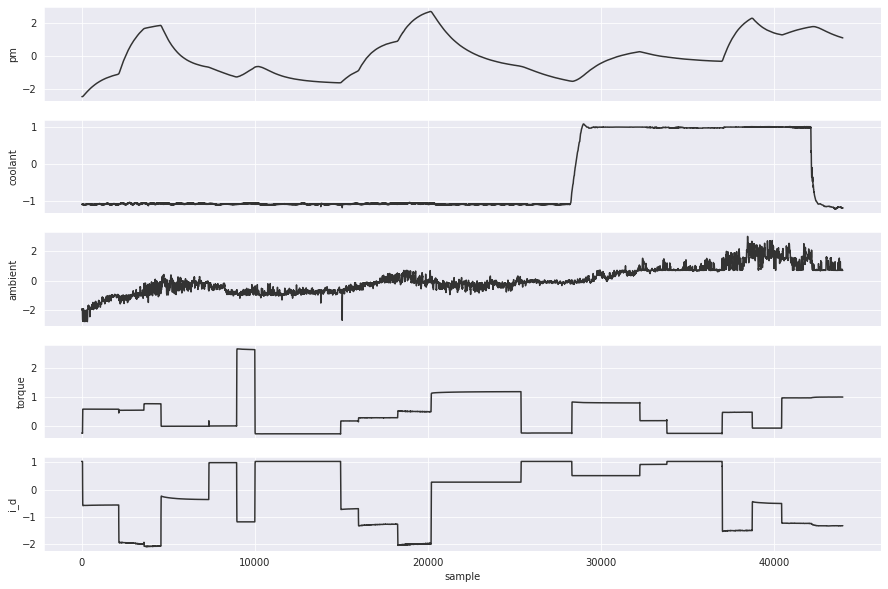

In [57]:
# example of long-time motor running
plot_profile_time_series(df, 20, features=['pm','coolant','ambient', 'torque', 'i_d'])

So, as we see short runnings of motor do not nave any insights about process.

Long-term runnings have more interesting process changes. Temperature of stator and rotor exponentially grows/declines after step change of the parameters. But we do not saw any strict dependency like step up -> grows or step down -> decline (there are many opposite variants). 

Let's add basic stator parameters. We could know about Joule–Lenz law: Q ~ I**2, where Q is heat emits in the conductor and I is the current magnitude in it)

Also, ambient temperature values are noizy, though we need to eliminate that noise with smoothing

In [58]:
def calculate_magnitude(value_d: pd.Series, value_q: pd.Series) -> pd.Series:
    return np.sqrt(value_d**2 + value_q**2)


def calculate_apparent_power(current: pd.Series, voltage: pd.Series) -> pd.Series:
    return current * voltage
    

def calculate_active_power(current_d: pd.Series, 
                           current_q: pd.Series, 
                           voltage_d: pd.Series, 
                           voltage_q: pd.Series) -> pd.Series:

    return current_d * voltage_d + current_q * voltage_q
    

def calculate_reactive_power(current_d: pd.Series, 
                             current_q: pd.Series, 
                             voltage_d: pd.Series, 
                             voltage_q: pd.Series) -> pd.Series:
                             
    return current_d * voltage_q - current_q * voltage_d

In [80]:
class StatorParametersTransformer(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X: pd.DataFrame, y: pd.Series = None) -> StatorParametersTransformer:
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return X.assign(**{
          'current': lambda x: calculate_magnitude(x["i_d"], x["i_q"]),
          'voltage': lambda x: calculate_magnitude(x["u_d"], x["u_q"]),
          'apparent_power': lambda x: calculate_apparent_power(x["current"], x["voltage"]),
          'active_power': lambda x: calculate_active_power(x["i_d"], x["i_q"], x["u_d"], x["u_q"]),
          'reactive_power': lambda x: calculate_reactive_power(x["i_d"], x["i_q"], x["u_d"], x["u_q"]),
        })

In [81]:
df_with_stator_parameters = StatorParametersTransformer().fit_transform(df)

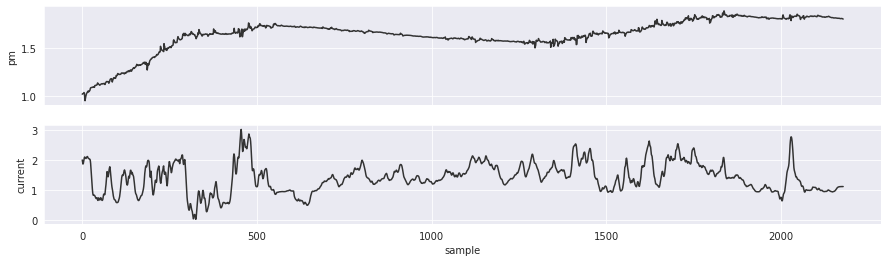

In [82]:
plot_profile_time_series(df_with_stator_parameters, 46, features=['pm','current'])

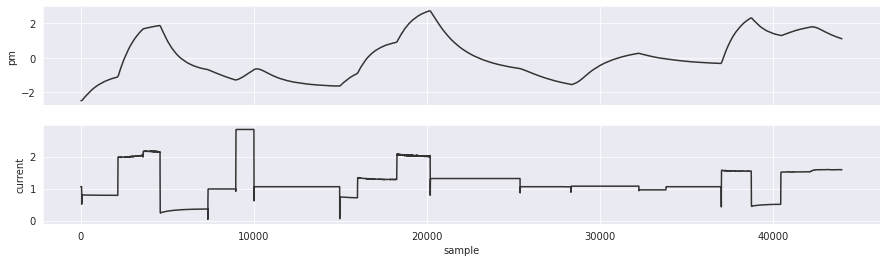

In [62]:
plot_profile_time_series(df_with_stator_parameters, 20, features=['pm','current'])

Now it is clear that steps in current magnitude produce exponential changes in temperatures

### Smoothed features

As we saw above, we need to know history of other parameters to estimate temperature. So we could generate exponentially smoothed features. More precisely, I will use Exponentially Weighted Moving Average (EWMA)

In [63]:
def groupby_and_extract(column: str, feature: str) -> Callable:
  def decorator(func: Callable) -> Callable:
    def wrapper(df: pd.DataFrame) -> DataFrameGroupBy:
      return func(df.groupby("profile_id")[feature])
    return wrapper
  return decorator
  

def define_ewma_calculation_func(feature_name: str, span: int) -> Callable:
  
  # TODO: Fine and clear, but group by for each new feature wired and not efficient. 
  # Need refactoring for multicolumn EWMA.
  @groupby_and_extract("profile_id", feature_name)
  def calculate_ewma(series: SeriesGroupBy) -> pd.Series:
    transformed_series: pd.Series = series.transform(lambda x: x.ewm(span, min_periods=1).mean())
    return transformed_series.reset_index(drop=True)
    
  return calculate_ewma


def define_ewma_features(features: List[str], spans: List[int]) -> Dict[str, Callable]:
  result: Dict[str, Callable] = dict()

  for feature, span in product(features, spans):
    feature_name: str = f"{feature}_ewma_{span}"
    calcualtion_func: Callable = define_ewma_calculation_func(feature, span)
    result[feature_name] = calcualtion_func

  return result

In [83]:
class EwmaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 columns: List[str] = [], 
                 spans: List[int] = [], 
                 drop_transformed: bool = True):
      
        self.columns = columns
        self.spans = spans
        self.drop_transformed = drop_transformed

    def set_params(self, **params):
        self.columns = params["columns"]
        self.spans = params["spans"]
        self.drop_transformed = params["drop_transformed"]

    def fit(self, X: pd.DataFrame, y: pd.Series = None) -> EwmaTransformer:
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        ewma_features: Dict[str, Callable] = define_ewma_features(self.columns, self.spans)
        return X.assign(**ewma_features).drop(self.columns if self.drop_transformed else [], axis=1)

In [84]:
class Debug(BaseEstimator, TransformerMixin):

    def __init__(self, title: str):
      self.title = title

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        print(self.title)
        print(f"Total shape: {X.shape}")
        print(f"NaN shape{X[X.isna().any(axis=1)].shape}\n\n")
        return X

    def fit(self, X: pd.DataFrame, y: pd.Series = None, **fit_params) -> Debug:
        return self

Let's combine all our code in pipelines:

- Step 1 : generate new features before grid search, because GridSearchCV make split on data, so ewma will not be correctly calculated

- Step 2: do some feature selection with KBest

- Step 3: evaluate grid search with Ridge regression

In [85]:
ewma_spans: List[int] = [1300, 3000, 5000]
ewma_columns: List[str] = ['ambient', 'coolant', 'u_d', 'u_q', 
                            'motor_speed', 'i_d','i_q', 'current', 'voltage', 
                            'apparent_power', 'active_power', 'reactive_power']

feature_tarnsformation_pipeline = make_pipeline(
    StatorParametersTransformer(),
    EwmaTransformer(ewma_columns, ewma_spans, drop_transformed=False),
)

new_features_df = feature_tarnsformation_pipeline.fit_transform(df)

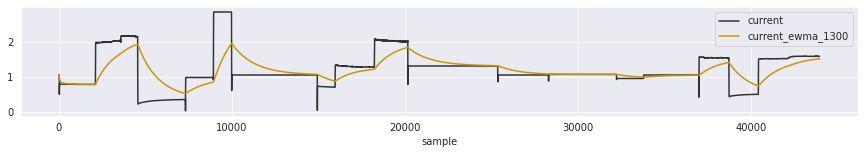

In [86]:
plot_profile_time_series_single_grid(new_features_df.reset_index(), 20, features=['current', 'current_ewma_1300'])

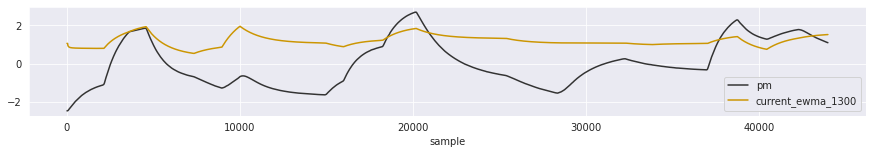

In [68]:
plot_profile_time_series_single_grid(new_features_df.reset_index(), 20, features=['pm', 'current_ewma_1300'])

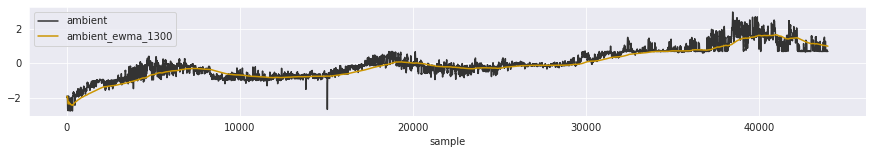

In [69]:
plot_profile_time_series_single_grid(new_features_df.reset_index(), 20, features=['ambient', 'ambient_ewma_1300'])

In [70]:
# Note that profile_id is needed for tests and evaluation, 
# so we will need to deal with it on the modelling steps
# maybe I should solved with moving this column to index

X = new_features_df.drop(columns=TARGET_FEATURES + ["profile_id"])
y = new_features_df["pm"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [71]:
# Use SelectKBest out of feature_tarnsformation_pipeline because of DataFrame interface
# We can change k and see how it influence on results
# K='all' is for all features selected

selector = SelectKBest(f_regression, k='all')
selector.fit_transform(X_train, y_train)
mask = selector.get_support()
selected_features = X_train.columns[mask]

X_train_filtered = X_train[selected_features]
X_test_filtered = X_test[selected_features]

selected_features

Index(['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q',
       'current', 'voltage', 'apparent_power', 'active_power',
       'reactive_power', 'ambient_ewma_1300', 'ambient_ewma_3000',
       'ambient_ewma_5000', 'coolant_ewma_1300', 'coolant_ewma_3000',
       'coolant_ewma_5000', 'u_d_ewma_1300', 'u_d_ewma_3000', 'u_d_ewma_5000',
       'u_q_ewma_1300', 'u_q_ewma_3000', 'u_q_ewma_5000',
       'motor_speed_ewma_1300', 'motor_speed_ewma_3000',
       'motor_speed_ewma_5000', 'i_d_ewma_1300', 'i_d_ewma_3000',
       'i_d_ewma_5000', 'i_q_ewma_1300', 'i_q_ewma_3000', 'i_q_ewma_5000',
       'current_ewma_1300', 'current_ewma_3000', 'current_ewma_5000',
       'voltage_ewma_1300', 'voltage_ewma_3000', 'voltage_ewma_5000',
       'apparent_power_ewma_1300', 'apparent_power_ewma_3000',
       'apparent_power_ewma_5000', 'active_power_ewma_1300',
       'active_power_ewma_3000', 'active_power_ewma_5000',
       'reactive_power_ewma_1300', 'reactive_power_ewma_3000',
       

In [72]:
model_pipline = Pipeline([
  ("regressor", Ridge())
])

params_grid = {
    "regressor__alpha": np.logspace(-8, 3, num=12, base=10),
    "regressor__fit_intercept": [True, False],
}

model = GridSearchCV(model_pipline, 
                     params_grid, 
                     scoring=make_scorer(r2_score), 
                     n_jobs=-1,
                     cv=10,
                     verbose=1,
                     refit=True,
                     return_train_score=True
                     )

model.fit(X_train_filtered, y_train)

cv_results_df = pd.DataFrame(model.cv_results_)
cv_results_df[["param_regressor__alpha", "param_regressor__fit_intercept", 
               "mean_train_score","std_train_score",
               "mean_test_score","std_test_score", 
               "rank_test_score"]]

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   47.2s finished


,param_regressor__alpha,param_regressor__fit_intercept,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
0,1e-08,True,0.908382,0.000263,0.908344,0.002373,6
1,1e-08,False,0.908304,0.000264,0.908266,0.002384,13
2,1e-07,True,0.908382,0.000263,0.908344,0.002373,5
3,1e-07,False,0.908304,0.000264,0.908266,0.002384,12
4,1e-06,True,0.908382,0.000263,0.908344,0.002373,4
5,1e-06,False,0.908304,0.000264,0.908266,0.002384,11
6,1e-05,True,0.908382,0.000263,0.908344,0.002373,3
7,1e-05,False,0.908304,0.000264,0.908266,0.002384,10
8,0.0001,True,0.908382,0.000263,0.908344,0.002373,2
9,0.0001,False,0.908304,0.000264,0.908266,0.002384,9


In [73]:
model.best_estimator_.named_steps['regressor'].coef_

array([-1.44841536e-02, -1.75985276e-01,  1.06927057e-01, -2.17568907e-01,
        2.61692017e-01,  1.74044335e-01,  8.47375280e-02, -5.20613950e-02,
        2.00622526e-03, -7.77109822e-02,  2.83709040e-02,  8.46195004e-02,
       -2.89968748e-01,  3.02199026e+00, -2.55547790e+00,  8.78475231e-01,
       -8.82396599e-01,  7.77348544e-01, -1.79726524e+00,  4.24792374e+00,
       -3.28142428e+00, -1.12640663e-01, -2.20981273e+00,  6.57463667e-01,
       -4.80279901e-02,  4.02036708e+00, -1.91215964e+00, -6.51476031e-01,
        2.68146420e+00, -1.30808622e+00, -1.48535926e+00,  4.50445349e+00,
       -3.29201063e+00, -6.39043576e-01,  5.87976588e+00, -5.15417345e+00,
       -1.31508905e+00,  6.42329578e+00, -4.84606695e+00,  1.21892858e+00,
       -5.51941679e+00,  4.19282926e+00, -5.08179265e-01,  1.08439799e+00,
       -1.06859838e+00, -3.33706257e-01,  1.51562282e+00, -7.05925533e-01])

Let's prepare helpers to eveluate our experiments with models

In [91]:
def evaluate_test(estimator: BaseEstimator, 
                  score: Callable, 
                  X_test: pd.DataFrame, 
                  y_test: pd.Series) -> float:
  
    y_pred = estimator.predict(X_test)
    return score(y_test, y_pred)

In [92]:
def score_on_profiles(df: pd.DataFrame, 
                      estimator: BaseEstimator, 
                      score: Callable, 
                      selected_features: Iterable, 
                      profile_ids: List[str]=None) -> List[Tuple]:
  
    profile_ids_to_score = df.profile_id.unique() if profile_ids is None else profile_ids
    
    result = list()
    for profile_id in profile_ids_to_score:
        df_profile = df[df.profile_id == profile_id]
        profile_score = evaluate_test(estimator, score, df_profile[selected_features], df_profile["pm"])
        result.append((int(profile_id), profile_score))

    return result

In [93]:
# df should have profile_id
def plot_fitted_values(df: pd.DataFrame, 
                       estimator: BaseEstimator,
                       selected_features: Iterable, 
                       profile_ids: List[str]=None) -> None:

    profile_ids_to_plot = df.profile_id.unique() if profile_ids is None else profile_ids

    with sns.axes_style(PLOT_STYLE):
        _, axes = plt.subplots(len(profile_ids_to_plot), 
                              1, 
                              figsize=(15, len(profile_ids_to_plot)*2))
        plt.xlabel("sample")

        for ax, profile_id in zip(axes, profile_ids_to_plot):
            df_profile = df[df.profile_id == profile_id]
            y_pred = estimator.predict(df_profile[selected_features]) #need just selected features
            y_true = df_profile["pm"].values

            ax.plot(y_true, color=PLOT_PRIMARY_COLOR, label="true")
            ax.plot(y_pred, color=PLOT_SECONDARY_COLOR, label="prediction")
            ax.legend()
            ax.set_ylabel(f"pm: pid {profile_id}")

In [94]:
score = evaluate_test(model.best_estimator_, r2_score, X_test_filtered, y_test)
f"Evaluation on test dataset result: {score: 0.3f}"

'Evaluation on test dataset result:  0.908'

In [95]:
scores = score_on_profiles(new_features_df, model.best_estimator_, r2_score, selected_features)
scores_df = pd.DataFrame(scores, columns=["profile_id", "score"]).sort_values(by=['score'], ascending=False).reset_index(drop=True)
scores_df

,profile_id,score
0,20,0.968196
1,32,0.959990
2,27,0.944702
3,4,0.943329
4,44,0.908295
5,6,0.908048
6,30,0.866156
7,29,0.865504
8,45,0.834010
9,48,0.792863


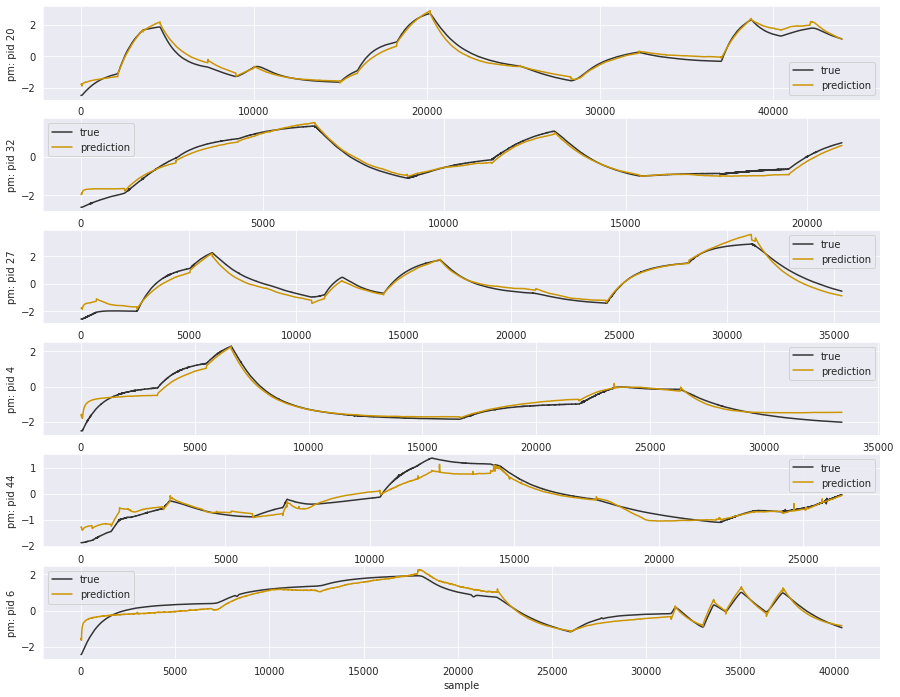

In [96]:
# good fittings:
best_5_fitted_profiles_id = scores_df.loc[0:5, "profile_id"].values
plot_fitted_values(new_features_df, model.best_estimator_, selected_features, best_5_fitted_profiles_id)

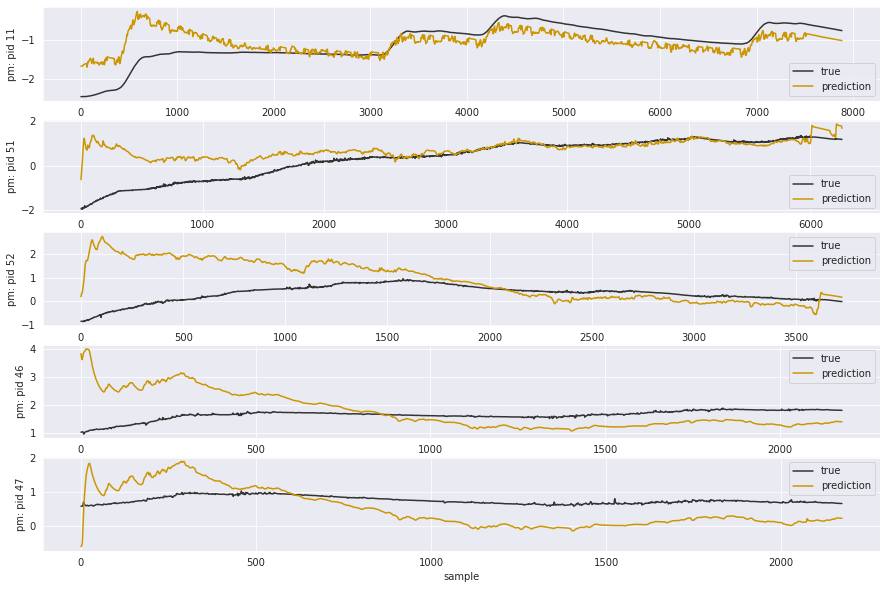

In [97]:
# worst fittings:
worst_5_fitted_profiles_id = scores_df.iloc[-5:]["profile_id"].values
plot_fitted_values(new_features_df, model.best_estimator_, selected_features, worst_5_fitted_profiles_id)

### Concluton on Ridge

1. PM temperature predicted very well for long-time running.
2. Due to exponential smoothing of features, prediction became more accurate after some time since start of running
3. Due to p.2, short runnings prediction is awful
4. In long runnings we can see some weak predictons
5. Error distributed not normally (we could see that without any plots)

### Ways to improve

1. Prepare more complex model
2. Include PCA in pipeline to reduce correlation of features
3. Change EWMA generation strategy for the beginning of the profile